# Setup

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os
import re
import joblib

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from gap_statistic import OptimalK

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    homogeneity_completeness_v_measure,
    fowlkes_mallows_score,
    classification_report,
    roc_auc_score
)

from sklearn import tree


## Global Configuration

In [2]:
INPUT_DIR = '../data/input/'
INPUT_PATH = f'{INPUT_DIR}german_data.csv'
OUTPUT_DIR = INPUT_DIR

EDA_DIR = '../data/EDA/'

FEATURE_INPUT_DIR = '../data/feature/step2/'
PIPELINE_INPUT_DIR = '../data/pipeline/step2/'

FEATURE_OUTPUT_DIR = '../data/feature/step3/'
PIPELINE_OUTPUT_DIR = '../data/pipeline/step3/'

FEATURE_TRAIN_PATH = '../data/feature/step1/03_pipeline_rare_freq_train.csv'
FEATURE_TEST_PATH = '../data/feature/step1/03_pipeline_rare_freq_test.csv'
PCA_TRAIN_PATH = '../data/feature/step2/04_pipeline_rare_freq_pca_train.csv'
PCA_TEST_PATH = '../data/feature/step2/04_pipeline_rare_freq_pca_test.csv'

OUTPUT = False
SEED = 888

In [3]:
if not os.path.exists(FEATURE_OUTPUT_DIR):
    os.makedirs(FEATURE_OUTPUT_DIR)
    
if not os.path.exists(PIPELINE_OUTPUT_DIR):
    os.makedirs(PIPELINE_OUTPUT_DIR)

In [4]:
pd.options.display.max_columns = None

In [5]:
COLOR_MAP = {0: '#00BFC4', 1: '#F8766D'}

## Global Function

In [6]:
def kmeans_optimalK(data, K):
    model = KMeans(random_state=SEED, max_iter=300)
    model.fit(data)
    return model.cluster_centers_, model.predict(data)

# Data

We decided to take rare encoding + frequency encoding -> pca pipeline due to the reason that they have obvious clustering patterns over their PC plots. From the PC components plot, we can somehow decide that thre will be 2-4 clusters, but we can still use other methods to judge whether if which k will be optimal.

In [7]:
df_train = pd.read_csv(FEATURE_TRAIN_PATH)
df_test = pd.read_csv(FEATURE_TEST_PATH)

X_train_pca = pd.read_csv(PCA_TRAIN_PATH)
X_test_pca = pd.read_csv(PCA_TEST_PATH)

X_train = df_train.drop('label', axis=1)
y_train = df_train.label

X_test = df_test.drop('label', axis=1)
y_test = df_test.label

X_train1 = pd.concat([X_train, X_train_pca], axis=1)
X_test1 = pd.concat([X_test, X_test_pca], axis=1)

In [8]:
display(
    df_train.shape,
    df_test.shape,
    X_train_pca.shape,
    X_test_pca.shape,
    X_train1.shape,
    X_test1.shape
)

(978, 21)

(300, 21)

(978, 5)

(300, 5)

(978, 25)

(300, 25)

# K Means Clustering

## Elbow Method

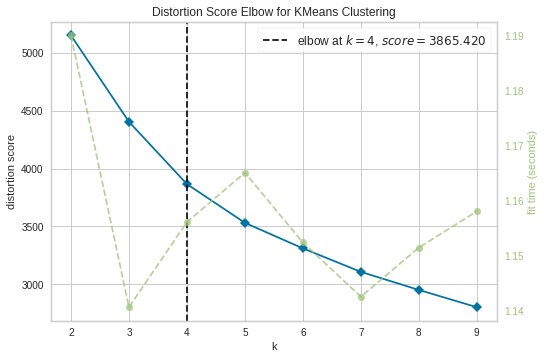

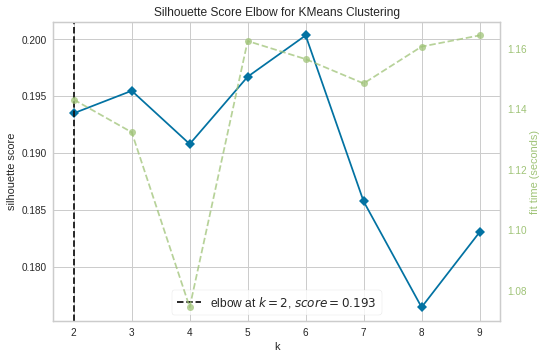

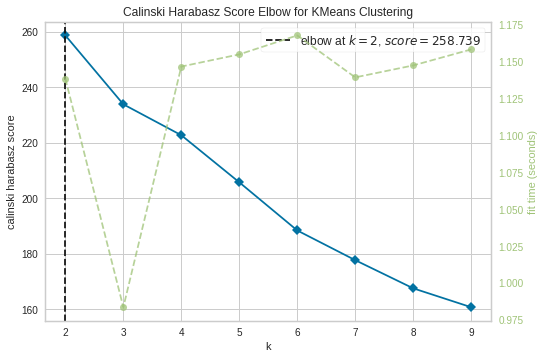

In [9]:
n_cluster_range = (2, 10)
metric_list = [
    'distortion',
    'silhouette',
    'calinski_harabasz'
]

model = KMeans(
    random_state=SEED,
    max_iter=300
)

optimal_k_set = set()

for metric in metric_list:
    visualizer = KElbowVisualizer(
        model, 
        k=n_cluster_range,
        timings=True,
        metric=metric
    )
    visualizer.fit(X_train)
    visualizer.show()
    optimal_k_set.add(visualizer.elbow_value_)
    plt.show()

In [10]:
optimal_k_set

{2, 4}

## Silhouette Method & Intercluster Distance

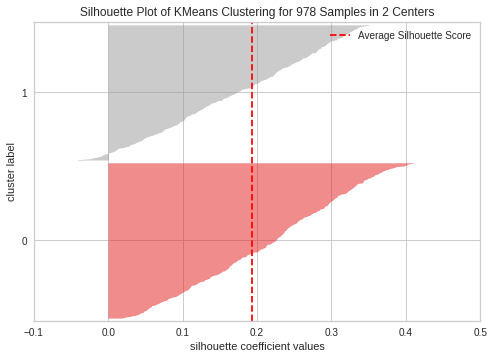

/home/jake/miniconda/envs/research/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


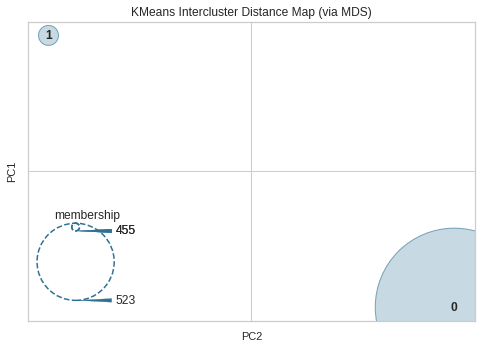

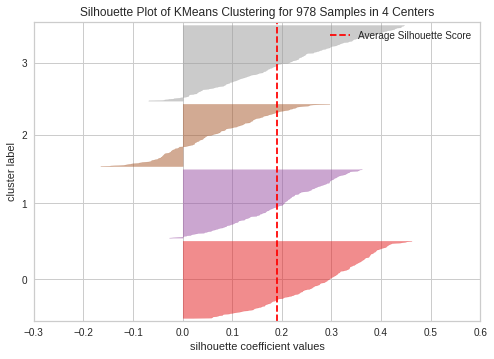

/home/jake/miniconda/envs/research/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


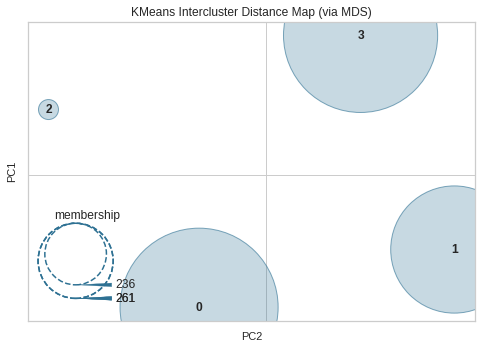

In [11]:
for i in optimal_k_set:
    model = KMeans(
        random_state=SEED,
        n_clusters=i
    )
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(X_train)
    visualizer.show()
    
    visualizer = InterclusterDistance(model)
    visualizer.fit(X_train)
    visualizer.show()

## Gap Statistics

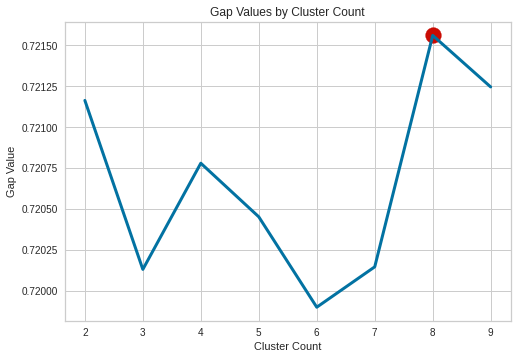

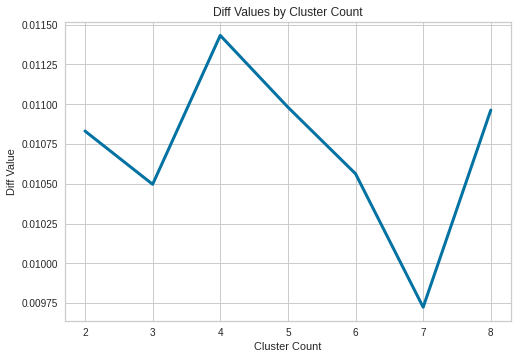

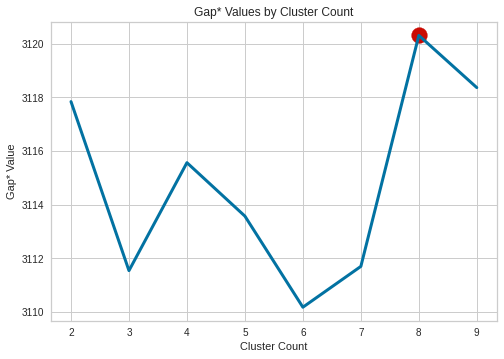

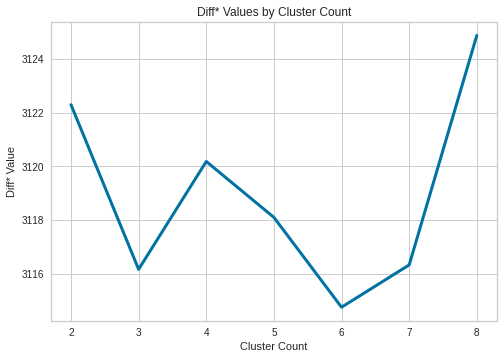

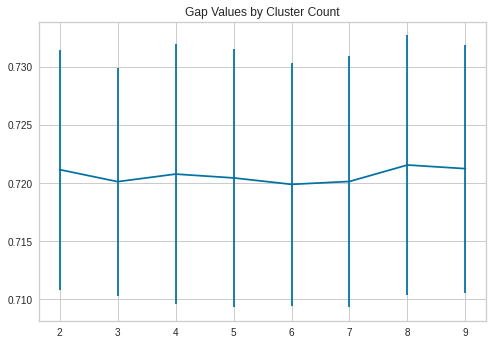

In [12]:
optimalK = OptimalK(n_jobs=-1, parallel_backend='joblib',
                    clusterer=kmeans_optimalK, n_iter=40)
n_clusters = optimalK(X_train, n_refs=400, cluster_array=np.arange(2, 10))
df_gap = optimalK.gap_df
optimalK.plot_results()

plt.errorbar(x=df_gap.n_clusters, y=df_gap.gap_value, yerr=df_gap.sk)
plt.title('Gap Values by Cluster Count')
plt.show()

# Feature Selection

As suggested by PCA loadings, we knew that 
- for categorical variables appear at least 4 times in top 3 highest / lowest loadings within each PC
    - credit_history
    - saving_accounts_or_bonds
    - other_installment_plans
    - housing
    - job
- for numerical variables appear at least 4 times in top 3 highest / lowest loading within each PC
    - duration_mth
    - installment_rate_percent
    - present_residence_since
    - monthly_affordability_amount

However, since our focus is to do a clustering over categorical variables to increase the explainability.

In [13]:
pca_suggested_categorical_features = [
    'credit_history', 
    'saving_accounts_or_bonds',
    'other_installment_plans',
    'housing',
    'job'
]

pca_suggested_numerical_features = [
    'duration_mth',
    'installment_rate_percent',
    'present_residence_since',
    'monthly_affordability_amount'
]

# Model Selection

In [14]:
selected_features = [
    col for col in X_train1.columns if re.findall('pc', col) != []
]

## PCA Features

### K=2

In [15]:
model = KMeans(random_state=SEED, max_iter=300, n_clusters=2)
X_train2 = X_train1.loc[:, selected_features]
X_test2 = X_test1.loc[:, selected_features]
model.fit(X_train2)

y_pred_train = pd.Series(model.predict(X_train2), name='cluster')
y_pred_test = pd.Series(model.predict(X_test2), name='cluster')

y_eval_train = pd.concat([y_train, y_pred_train], axis=1)
y_eval_test = pd.concat([y_test, y_pred_test], axis=1)

In [16]:
display(
    y_eval_train.cluster.value_counts(),
    y_eval_train.groupby('cluster').label.value_counts(normalize=True)
)

1    858
0    120
Name: cluster, dtype: int64

cluster  label
0        0        0.591667
         1        0.408333
1        1        0.512821
         0        0.487179
Name: label, dtype: float64

In [17]:
display(
    y_eval_test.cluster.value_counts(),
    y_eval_test.groupby('cluster').label.value_counts(normalize=True)
)

1    234
0     66
Name: cluster, dtype: int64

cluster  label
0        0        0.590909
         1        0.409091
1        0        0.735043
         1        0.264957
Name: label, dtype: float64

Due to the reason that we have a majority cluster over here, hence we decided to take K=4.

### K=4

In [18]:
model = KMeans(random_state=SEED, max_iter=300, n_clusters=4)
X_train2 = X_train1.loc[:, selected_features]
X_test2 = X_test1.loc[:, selected_features]
model.fit(X_train2)

y_pred_train = pd.Series(model.predict(X_train2), name='cluster')
y_pred_test = pd.Series(model.predict(X_test2), name='cluster')

y_eval_train = pd.concat([y_train, y_pred_train], axis=1)
y_eval_test = pd.concat([y_test, y_pred_test], axis=1)

In [19]:
display(
    y_eval_train.cluster.value_counts(),
    y_eval_train.groupby('cluster').label.value_counts(normalize=True)
)

1    523
2    168
3    167
0    120
Name: cluster, dtype: int64

cluster  label
0        0        0.591667
         1        0.408333
1        1        0.674952
         0        0.325048
2        0        0.625000
         1        0.375000
3        0        0.856287
         1        0.143713
Name: label, dtype: float64

In [20]:
display(
    y_eval_test.cluster.value_counts(),
    y_eval_test.groupby('cluster').label.value_counts(normalize=True)
)

1    102
2     70
0     66
3     62
Name: cluster, dtype: int64

cluster  label
0        0        0.590909
         1        0.409091
1        0        0.764706
         1        0.235294
2        0        0.600000
         1        0.400000
3        0        0.838710
         1        0.161290
Name: label, dtype: float64

Train Data Set
- Cluster 0, 2, 3: good payer
- Cluster 1: bad payer

Test Data Set
- Cluster 0, 1, 2, 3 are good payer

Finalize to use k = 3 for categorical variables

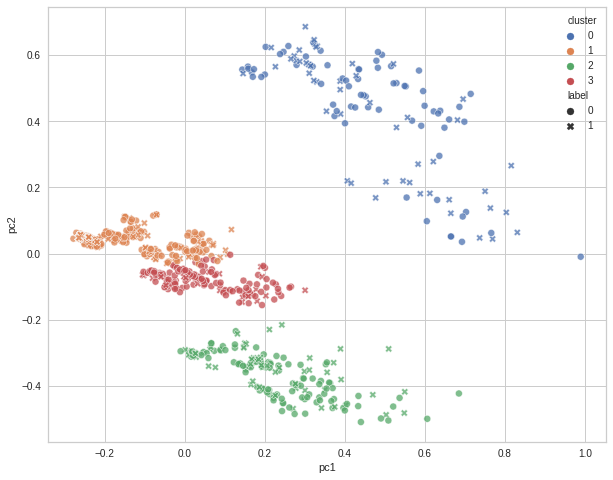

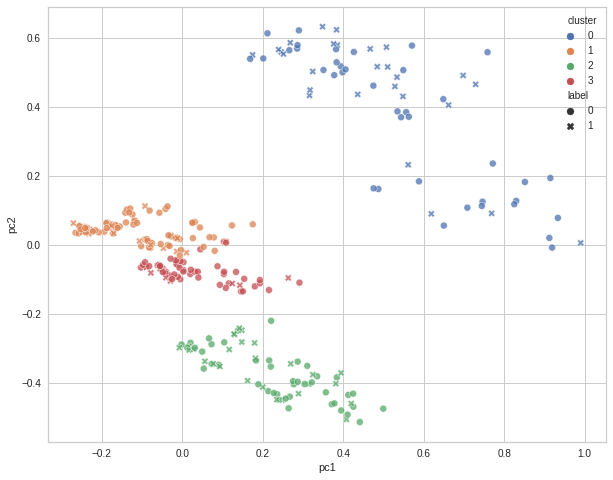

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(
    data=X_train1,
    x='pc1',
    y='pc2',
    hue=y_pred_train,
    style=y_train,
    alpha=0.75,
    palette='deep',
    ax=ax
)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(
    data=X_test1,
    x='pc1',
    y='pc2',
    hue=y_pred_test,
    style=y_test,
    alpha=0.75,
    palette='deep',
    ax=ax
)
plt.show()

## Cluster Analysis Using Decision Tree

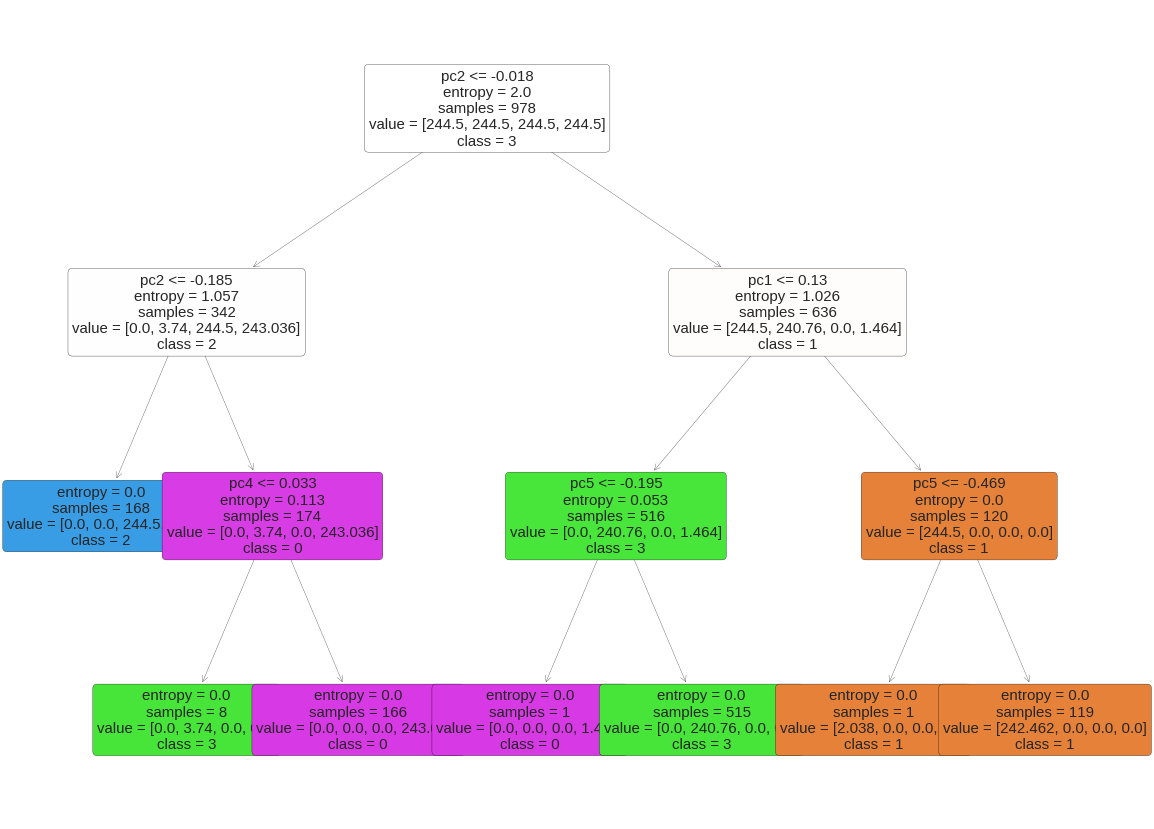

In [22]:
clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=SEED, 
    class_weight='balanced', 
    min_samples_split=100
)
clf.fit(X_train1.loc[:, selected_features], y_pred_train)

class_names = y_pred_train.unique().astype(str)
fig, ax = plt.subplots(figsize=(20,15))
dot_data = tree.plot_tree(clf, 
                          feature_names=selected_features,
                          class_names=class_names,
                          ax=ax,
                          filled=True,
                          fontsize=15,
                          rounded=True)
plt.savefig('tree.png')

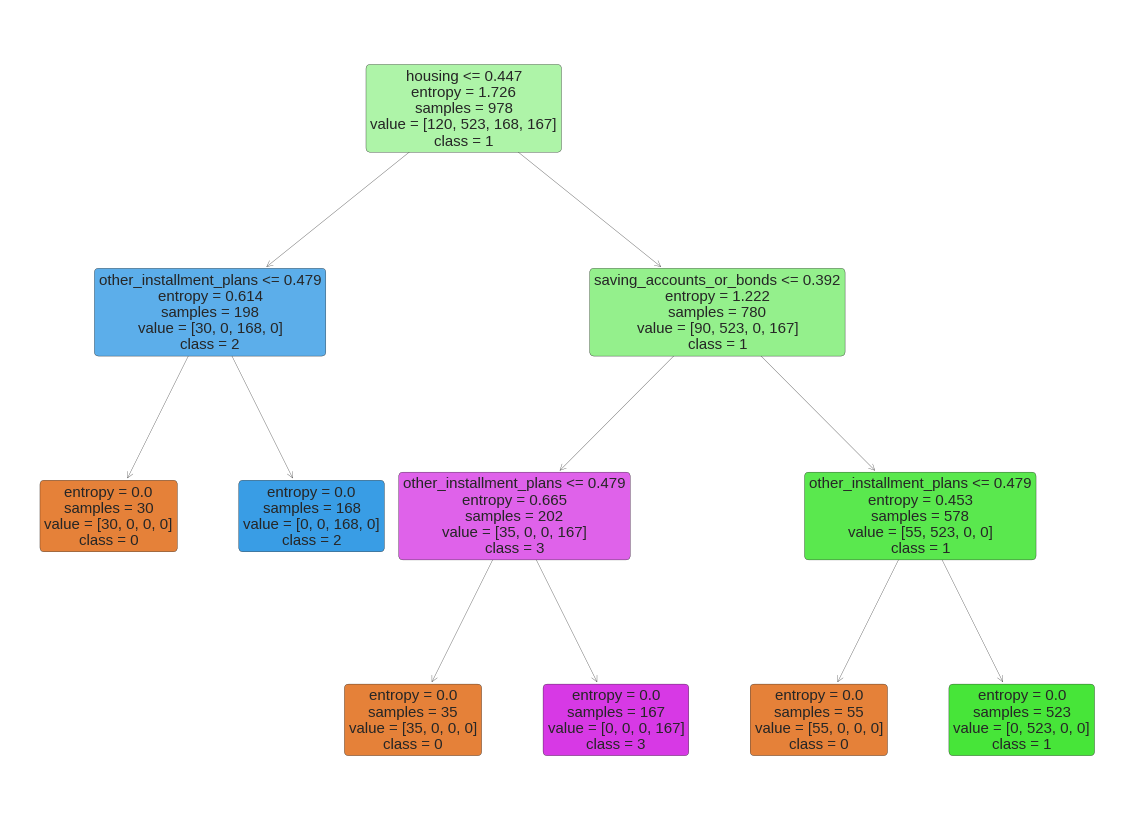

In [23]:
clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=SEED,  
    min_samples_split=100
)
clf.fit(X_train1.loc[:, pca_suggested_categorical_features], y_pred_train)

class_names = sorted(y_pred_train.unique().astype(str))
fig, ax = plt.subplots(figsize=(20,15))
dot_data = tree.plot_tree(clf, 
                          feature_names=pca_suggested_categorical_features,
                          class_names=class_names,
                          ax=ax,
                          filled=True,
                          fontsize=15,
                          rounded=True)
plt.savefig('tree.png')

In [24]:
path = '../data/pipeline/step1/03_pipeline_rare_freq.pkl'
pipeline = joblib.load(path)

for feature in pca_suggested_categorical_features:
    print(feature)
    print(pipeline[1].encoder_dict_[feature])

credit_history
{'A32': 0.5214285714285715, 'A34': 0.3, 'A33': 0.09285714285714286, 'RARE': 0.08571428571428572}
saving_accounts_or_bonds
{'A61': 0.6057142857142858, 'A65': 0.17857142857142858, 'A62': 0.10428571428571429, 'A63': 0.06571428571428571, 'RARE': 0.045714285714285714}
other_installment_plans
{'A143': 0.8285714285714286, 'A141': 0.12857142857142856, 'RARE': 0.04285714285714286}
housing
{'A152': 0.7171428571428572, 'A151': 0.17714285714285713, 'A153': 0.10571428571428572}
job
{'A173': 0.6271428571428571, 'A172': 0.20714285714285716, 'A174': 0.14285714285714285, 'RARE': 0.022857142857142857}


Rules 1
- housing = A151, A153
- other_installment_plan != A143 THEN CLASS 0
- other_installment_plan = A143 THEN CLASS 2

Rules 2
- housing = A152
- saving_accounts_or_bonds != A61
- other_installment_plans != A143 THEN CLASS 0
- saving_accounts_or_bonds = A143 THEN CLASS 3

Rules 3
- housing = A152
- saving_accounts_or_bonds = A61
- other_installment_plans != A143 THEN CLASS 0
- saving_accounts_or_bonds = A143 THEN CLASS 1 

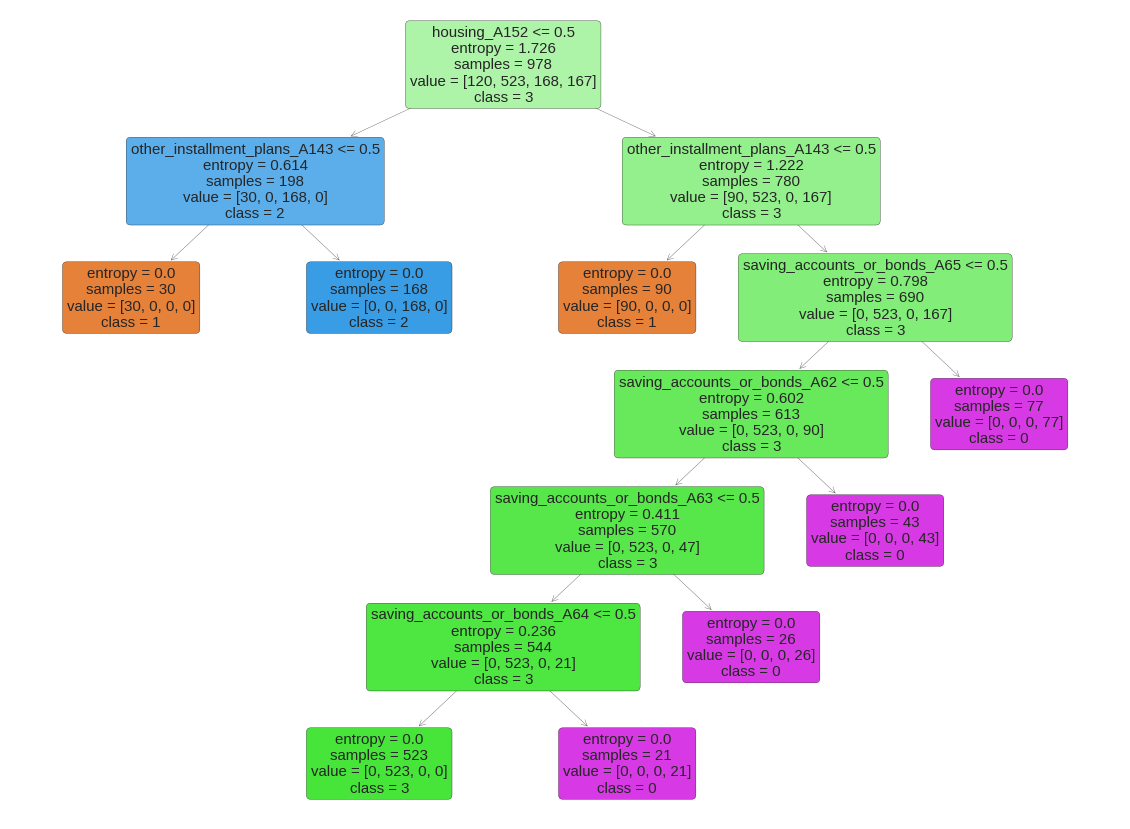

In [25]:
path = '../data/feature/step1/02_pipeline_smote_train.csv'
df_smote_train = pd.read_csv(path)
df_smote_train = pd.get_dummies(df_smote_train.loc[:, pca_suggested_categorical_features], drop_first=True)


clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=SEED,  
    min_samples_split=100
)
clf.fit(
    df_smote_train, y_pred_train
)

class_names = y_pred_train.unique().astype(str)
fig, ax = plt.subplots(figsize=(20,15))
dot_data = tree.plot_tree(clf, 
                          feature_names=df_smote_train.columns,
                          class_names=class_names,
                          ax=ax,
                          filled=True,
                          fontsize=15,
                          rounded=True)
plt.savefig('tree.png')